# 1. PyTorch transfer learning

## 1.1 setup and data

In [1]:
import time, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps")

In [4]:
# CIFAR-10 统计（这里用 CIFAR 均值和方差，而不是 ImageNet 的）
mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)

In [6]:
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #random crop with padding
    transforms.RandomHorizontalFlip(), #random horizontal flip
    transforms.ToTensor(), # to tensor
    transforms.Normalize(mean, std), #normalize per channel
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [7]:
train_set = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfms)
test_set = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)

## 1.2 Training utils

In [9]:
def accuracy_from_logits(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

In [13]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, tot = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy_from_logits(logits, y) * bs
        tot += bs
    return total_loss / tot, total_acc / tot

In [14]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()                              # train mode / 训练模式
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)  # clear grads efficiently / 高效清梯度
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()                        # backprop / 反向传播
        optimizer.step()                       # update params / 参数更新
        bs = x.size(0)
        tot_loss += loss.item() * bs
        tot_acc  += accuracy_from_logits(logits, y) * bs
        n += bs
    return tot_loss / n, tot_acc / n

## 1.3 Runners

In [15]:
try:
    IMAGENET_W = models.ResNet18_Weights.IMAGENET1K_V1   # new weights API
except:
    IMAGENET_W = "IAMGENET1K_V1"  # fallback for older torchvision

In [16]:
def build_resnet18(mode="scratch", num_classes=10):
    """
    mode:
      - 'scratch': random init, train all / 随机初始化，训练全部层
      - 'freeze' : load ImageNet, freeze backbone, train fc / 加载预训练，冻结骨干，仅训练fc
      - 'finetune': load ImageNet, unfreeze layer4+fc / 加载预训练，解冻layer4和fc
    """
    if mode == "scratch":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        params = [{"params": model.parameters(), "lr": 1e-3}]
    elif mode == "freeze":
        model = models.resnet18(weights=IMAGENET_W)
        for p in model.parameters():
            p.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        params = [{"params": model.fc.parameters(), "lr": 5e-3}]
    elif mode == "finetune":
        model = models.resnet18(weights=IMAGENET_W)
        for p in model.parameters():
            p.requires_grad = False
        for p in model.layer4.parameters():
            p.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        params = [
            {"params": model.layer4.parameters(), "lr":  5e-4},
            {"params": model.fc.parameters(), "lr": 1e-3}
        ]
    return model.to(device), params

In [17]:
def run_experiment(mode, epochs=10, wd=1e-4):
    model, param_groups = build_resnet18(mode)
    optimizer = torch.optim.AdamW(param_groups, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
    hist = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
    for ep in range(1, epochs+1):
        trL, trA = train_one_epoch(model, train_loader, optimizer, criterion)
        teL, teA = evaluate(model, test_loader, criterion)
        hist["train_loss"].append(trL)
        hist["train_acc"].append(trA)
        hist["test_loss"].append(teL)
        hist["test_acc"].append(teA)
        print(f"[{mode:9s}] ep{ep:02d} | train {trL:.4f} / {trA:.4f} | test {teL:.4f} / {teA:.4f}")
    return model, hist

In [18]:
EPOCHS = 10
scratch_model, scratch_hist = run_experiment("scratch", epochs=EPOCHS)
freeze_model, freeze_hist = run_experiment("freeze", epochs=EPOCHS)
ft_model, ft_hist = run_experiment("finetune", epochs=EPOCHS)

[scratch  ] ep01 | train 1.5408 / 0.4419 | test 1.2940 / 0.5366
[scratch  ] ep02 | train 1.1753 / 0.5798 | test 1.0729 / 0.6260
[scratch  ] ep03 | train 1.0095 / 0.6431 | test 0.9746 / 0.6529
[scratch  ] ep04 | train 0.9092 / 0.6789 | test 0.8433 / 0.7067
[scratch  ] ep05 | train 0.8402 / 0.7058 | test 0.8700 / 0.7015
[scratch  ] ep06 | train 0.7836 / 0.7246 | test 0.7793 / 0.7287
[scratch  ] ep07 | train 0.7289 / 0.7453 | test 0.7969 / 0.7231
[scratch  ] ep08 | train 0.6949 / 0.7566 | test 0.6830 / 0.7649
[scratch  ] ep09 | train 0.6568 / 0.7720 | test 0.7437 / 0.7483
[scratch  ] ep10 | train 0.6238 / 0.7807 | test 0.6369 / 0.7821


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mamba/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█| 44.7M/44.7M [00:03<00:00, 14.4MB


[freeze   ] ep01 | train 1.8940 / 0.3523 | test 1.9292 / 0.3673
[freeze   ] ep02 | train 1.8386 / 0.3746 | test 1.9464 / 0.3690
[freeze   ] ep03 | train 1.8380 / 0.3753 | test 1.8987 / 0.3823
[freeze   ] ep04 | train 1.8452 / 0.3728 | test 1.9383 / 0.3647
[freeze   ] ep05 | train 1.8321 / 0.3772 | test 1.9017 / 0.3799
[freeze   ] ep06 | train 1.8572 / 0.3739 | test 1.9243 / 0.3627
[freeze   ] ep07 | train 1.8448 / 0.3744 | test 1.9039 / 0.3774
[freeze   ] ep08 | train 1.8341 / 0.3767 | test 1.8810 / 0.3858
[freeze   ] ep09 | train 1.8383 / 0.3773 | test 1.8772 / 0.3873
[freeze   ] ep10 | train 1.8353 / 0.3778 | test 1.8380 / 0.3871
[finetune ] ep01 | train 1.3269 / 0.5321 | test 1.2552 / 0.5857
[finetune ] ep02 | train 1.0739 / 0.6260 | test 1.0226 / 0.6514
[finetune ] ep03 | train 0.9969 / 0.6486 | test 1.0182 / 0.6484
[finetune ] ep04 | train 0.9511 / 0.6650 | test 0.9866 / 0.6689
[finetune ] ep05 | train 0.9096 / 0.6792 | test 0.9362 / 0.6812
[finetune ] ep06 | train 0.8850 / 0.6853

## 1.4 Compare 

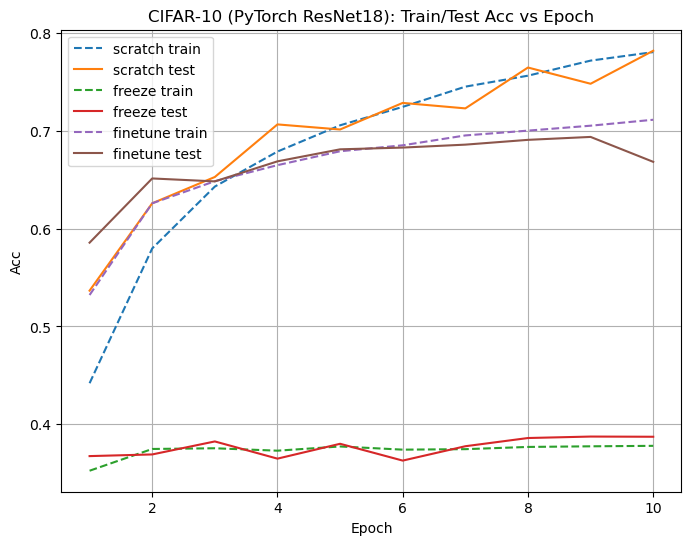

In [20]:
def plot_acc(h1, h2, h3, labels=("scratch","freeze","finetune")):
    ep = range(1, len(h1["train_acc"])+1)
    plt.figure(figsize=(8,6))
    #准确率
    plt.plot(ep, np.array(h1["train_acc"]), "--", label=f"{labels[0]} train")
    plt.plot(ep, np.array(h1["test_acc"]),  "-",  label=f"{labels[0]} test")
    plt.plot(ep, np.array(h2["train_acc"]), "--", label=f"{labels[1]} train")
    plt.plot(ep, np.array(h2["test_acc"]),  "-",  label=f"{labels[1]} test")
    plt.plot(ep, np.array(h3["train_acc"]), "--", label=f"{labels[2]} train")
    plt.plot(ep, np.array(h3["test_acc"]),  "-",  label=f"{labels[2]} test")
    plt.title("CIFAR-10 (PyTorch ResNet18): Train/Test Acc vs Epoch")
    plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.grid(True); plt.show()

plot_acc(scratch_hist, freeze_hist, ft_hist)

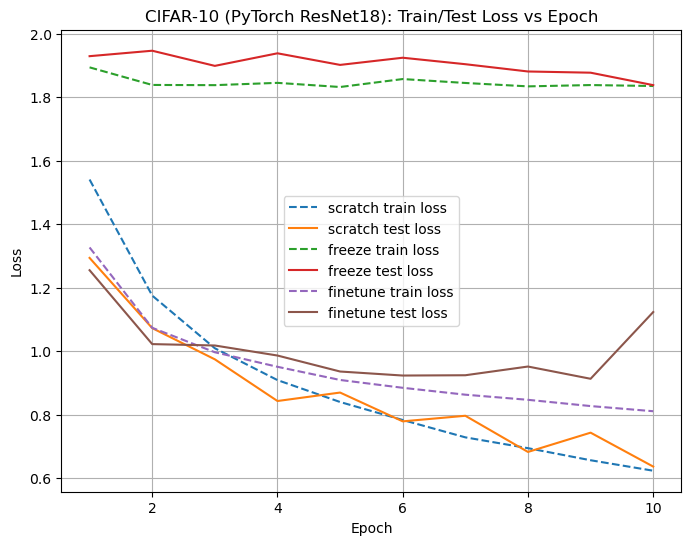

In [22]:
def plot_losses(h1, h2, h3, labels=("scratch","freeze","finetune"), logy=False):
    """
    画出三种训练模式的训练/测试损失曲线（loss curves）
    - h*: 历史字典，需包含 "train_loss" 与 "test_loss"
    - labels: 曲线标签
    - logy: 是否使用对数Y轴（log scale），损失跨度大时更易读
    """
    ep = range(1, len(h1["train_loss"]) + 1)
    plt.figure(figsize=(8, 6))

    for hist, name in zip([h1, h2, h3], labels):
        plt.plot(ep, hist["train_loss"], "--", label=f"{name} train loss")
        plt.plot(ep, hist["test_loss"],  "-",  label=f"{name} test loss")

    plt.title("CIFAR-10 (PyTorch ResNet18): Train/Test Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if logy:
        plt.yscale("log")  # 对数坐标（log scale）
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(scratch_hist, freeze_hist, ft_hist, logy=False) 

## 1.5 Freeze model ACC is low

用倒数第二层特征（penultimate features）做线性探测

In [23]:
import torch
import torch.nn as nn
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler   # 标准化（standardization）
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def extract_penultimate_features(model, loader, device):
    """
    抽取倒数第二层特征（penultimate features）
    对 torchvision ResNet：相当于去掉最后的 fc（classifier），
    保留到全局平均池化（global avgpool）并展平（flatten）。
    """
    # 去掉最后一层 fc，得到特征提取器（feature extractor）
    feat_extractor = nn.Sequential(*list(model.children())[:-1]).to(device).eval()

    feats, labels = [], []
    with torch.inference_mode():  # = no_grad 更省开销（inference mode）
        for x, y in loader:
            x = x.to(device)
            f = feat_extractor(x)            # [N, C, 1, 1]
            f = torch.flatten(f, 1)          # -> [N, C]
            feats.append(f.cpu().numpy())
            labels.append(y.cpu().numpy())
    X = np.concatenate(feats, axis=0)        # [N_total, C]
    y = np.concatenate(labels, axis=0)       # [N_total]
    return X, y

def linear_probe_on_penultimate(model, train_loader, test_loader, device):
    # 1) 抽特征
    Xtr, ytr = extract_penultimate_features(model, train_loader, device)
    Xte, yte = extract_penultimate_features(model, test_loader,  device)

    # 2) LogisticRegression：用标准化（StandardScaler）+ 多分类（multinomial）
    # 说明：
    # - solver 可选 'lbfgs'（稳）或 'saga'（可并行 & 稀疏友好）；这里先用 lbfgs。
    # - 若数据量较大或想并行，可把 solver='saga' 并设置 n_jobs=-1。
    clf = make_pipeline(
        StandardScaler(),  # 标准化能显著稳定线性分类器
        LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', C=1.0, random_state=42)
    )

    # 3) 训练与评估
    clf.fit(Xtr, ytr)
    yhat_tr = clf.predict(Xtr)
    yhat_te = clf.predict(Xte)
    tr_acc = accuracy_score(ytr, yhat_tr)
    te_acc = accuracy_score(yte, yhat_te)
    print(f"[Linear Probe] train acc = {tr_acc:.4f} | test acc = {te_acc:.4f}")
    return clf, (tr_acc, te_acc)

# 调用（用你训练好的 freeze_model）
clf, (lp_tr_acc, lp_te_acc) = linear_probe_on_penultimate(freeze_model, train_loader, test_loader, device)

/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Linear Probe] train acc = 0.4545 | test acc = 0.4095


In [25]:
print(f"LinearProbe  train acc={lp_tr_acc:.4f}  test acc={lp_te_acc:.4f}")
print(f"Freeze model test acc={freeze_hist['test_acc'][-1]:.4f}")  # 和线性探测对比

LinearProbe  train acc=0.4545  test acc=0.4095
Freeze model test acc=0.3871


这说明在冻结骨干（frozen backbone / feature extractor）的前提下，你的倒数第二层特征（penultimate features）对当前数据并不够线性可分（not linearly separable）。两点解读：

总体偏低（overall low）：虽然明显高于随机猜测的 10%（CIFAR-10），但对 ResNet18 这样的骨干来说依然偏低 ⇒ 冻结特征对你的数据/设置不够合适（domain/scale mismatch）。

泛化差距小（small generalization gap）：train≈0.45 vs test≈0.41，差距很小，像是欠拟合（underfitting）的线性头（linear head），不是过拟合；根因更可能在特征本身而非分类器容量。

# 2. Tensorflow transfer learning

## 2.1 Setup and data

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [29]:
AUTO = tf.data.AUTOTUNE
BATCH = 128
IMG_SIZE = 224 #Tensorflow here we use ResNet-50 (instead of ResNet-18 in PyTorch), and its default input size is 224

In [30]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [35]:
def tf_preprocess(images, labels, train=True):
    #resize to 224 * 224 for ResNet-50
    images = tf.image.resize(images, (IMG_SIZE, IMG_SIZE))
    if train:
        images = tf.image.random_flip_left_right(images) #data aug
    images = preprocess_input(images)
    return images, labels

In [36]:
train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .map(lambda a, b: tf_preprocess(a, b, True), num_parallel_calls=AUTO)
            .batch(BATCH)
            .prefetch(AUTO))

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
            .map(lambda a, b: tf_preprocess(a, b, False), num_parallel_calls=AUTO)
            .batch(BATCH)
            .prefetch(AUTO))

## 2.2 Model builders and trainers

In [39]:
def build_resnet50_keras(mode="scratch", num_classes=10, lr_head=1e-3):
    """
    mode:
      - 'scratch' : weights=None, train all / 不用预训练，全部可训练
      - 'freeze'  : weights='imagenet', base frozen / 用预训练，冻结骨干，训top
      - 'finetune': weights='imagenet', unfreeze last stage / 用预训练，解冻最后stage
    """
    if mode == "scratch":
        base = ResNet50(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3)) #include_top=False, is without top classifier
        base.trainable = True #train all
        inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = base(inp, training=True)
        x = layers.GlobalAveragePooling2D()(x)
        out = layers.Dense(num_classes, activation="softmax")(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(1e-3),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        return model

    elif mode == "freeze":
        base = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
        base.trainable = False
        inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = base(inp, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        out = layers.Dense(num_classes, activation="softmax")(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(lr_head),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        return model
    elif mode == "finetune":
        base = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
        base.trainable = False

        #unfreeze last stage
        for layer in base.layers:
            if layer.name.startswith("conv5_"):
                layer.trainable = True
        
        inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = base(inp, training=True)
        x = layers.GlobalAveragePooling2D()(x)
        out = layers.Dense(num_classes, activation="softmax")(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(lr_head),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        return model
        

In [ ]:
def train_keras(mode, epochs=1):
    model = build_resnet50_keras(mode)
    # fit returns History with accuracy/val_accuracy / fit返回训练与验证准确率曲线
    hist = model.fit(train_ds, validation_data=test_ds, epochs=epochs, verbose=1)
    return model, hist

# Run three modes / 运行三种模式
EPOCHS_TF = 1
model_scr, hist_scr = train_keras("scratch",  epochs=EPOCHS_TF)
model_frz, hist_frz = train_keras("freeze",   epochs=EPOCHS_TF)
model_ft,  hist_ft  = train_keras("finetune", epochs=EPOCHS_TF)

 39/391 [=>............................] - ETA: 1:20:30 - loss: 2.5158 - accuracy: 0.2342